# Идентификация функции приспособленности с использованием нейронных сетей

Функция фитнеса имеет вид:


$$
R(x) = \int\limits_0^1 \alpha E(x)\,dt - \int\limits_0^1 \gamma S_x(x) (cos(2\pi t) + 1)\,dt - \int\limits_0^1 \beta (x')^2\,dt  - \int\limits_0^1 \delta G(x)\,dt 
$$ где $x$ - стратегия поведения.


Введем $M_0, M_1, M_2, M_3$
$$
M_0 = \int\limits_0^1 E(x)\,dt = \int\limits_0^1 \sigma_1(x+C)\,dt \\
M_1 =  - \int\limits_0^1 S_x(x) (cos(2\pi t) + 1)\,dt = - \int\limits_0^1  \sigma_2(x+C)(cos(2\pi t) + 1)\,dt \\
M_2 = -\int\limits_0^1 (x')^2\,dt \\
M_3 = -\int\limits_0^1 G(x)\,dt = - \int\limits_0^1 (x + C_0)^2\,dt \\
$$

Функция $R$ примет вид:$$
R = \alpha M_0 + \gamma M_1 + \beta M_2 + \delta M_3
$$

Введем аппроксимацию для $x$, используя первое слагаемое в разложении функции в ряд Фурье:
$$ x = A + Bcos(2\pi t),$$ где $A$ - глубина погружения, а $B$ - амплитуда колебаний.

Введем аппроксимации функций состояния окружающей среды:

$$E = \sigma_1 (x + C), -C < x < 0 \\
S_x = \sigma_2 (x + C) \\
S_t=cos(2\pi t) + 1, 0 < t < 1 \\
G = (x + C_0)^2
$$

Где $C$ - максимальная глубина, $C_0$ - оптимальная глубина

Подставляя вместо $x, E, S_x, S_t, G$ соответствуюшие аппроксимации, после подсчета интегралов получаем:
$$
M_0 = \sigma_1 (A+C) \\
M_1 = -\sigma_2 (A + C + \frac{B}{2}) \\
M_2 = -\frac{(2\pi)^2 B^2}{2}\\
M_3 = -((A + C_0)^2 + \frac{B^2}{2})
$$

Таким образом, нашей задачей будет восстановление функции $R$, тоесть нахождение коэффицентов $\alpha, \gamma, \beta, \delta$, для удобства переобзначим их в $\lambda_0, \lambda_1, \lambda_2, \lambda_3$

Тогда если $ \lambda = (\lambda_0, \lambda_1, \lambda_2, \lambda_3)$, а $M = (M_0, M_1, M_2, M_3)$, то $R = (\lambda, M)$ (скалярное произведение векторов)

### Генерация обучающей выборки

Для калибровки и проверки корректности модели нейросети "играем в открытую", тоесть используем заранее известные параметры среды $C = 140, C_0 = 60, \sigma_1 = 0.25, \sigma_2 = 0.003$ и известные результаты компьютерных симуляций $\sigma_1 \lambda_0 = 0.1, \sigma_2 \lambda_1 = 1, \lambda_3 = 0.1, \lambda_2 = 0.000025$. Получаем $$\lambda_0 = \frac{0.1}{\sigma_1}, \lambda_1 = \frac{1}{\sigma_2}, \lambda_2 = 0.000025, \lambda_3 = 0.1$$ 

Зададим коэффициенты $\lambda, C, C_0, \sigma_1, \sigma_2$ и опишем функцию $R$
 
Уточненные данные $\alpha = 0.5, \gamma = 1, \beta = 0.000025, \delta = 0.01$

In [23]:
sigm1 = 0.25
sigm2 = 0.003
C0 = 60
C = 140
#lam = [0.1 / sigm1, 1 / sigm2, 0.000025, 0.1]
lam = [2, 333, 0.000025, 0.01]
#lam = [0.5, 1, 0.000025, 0.01]

Напишем функции $M_0, M_1, M_2, M_3$

In [24]:
import numpy as np

def M0(A, B, C, C0):
    return sigm1 * (A + C)

def M1(A, B, C, C0):
    return -sigm2 * (A + C + B / 2)

def M2(A, B, C, C0):
    return -4 * (np.pi) * (np.pi) * B * B / 2

def M3(A, B, C, C0):
    return -((A + C0) * (A + C0) + B * B / 2)

def M(A, B, C, C0):
    u = (A, B, C, C0)
    return M0(*u), M1(*u), M2(*u), M3(*u)

Теперь напишем функцию активации, фитнеса и нейрон.

In [25]:
def activation_func(x):
    if x > 0:
        return 1
    return -1

#это и есть функция R
def fitness(A, B, C, C0):
    a = (A, B, C, C0)
    return np.dot(M(*a), lam)

def neuron(u, v):
    return activation_func(fitness(*u) - fitness(*v))


Теперь попробуем сгенерировать различные стратегии поведения (коэффициенты $A$ и $B$) учтем условие $-C < x < 0$, получаем условия на $A$ и $B$:
$$ -C < A < 0, \\ |B| < min(A + C, -A) $$
Сгенерируем случайную выборку по заданным ограничениям

In [26]:
from random import randint
import pandas as pd

def gen_AB():
    A = randint(-C * 100, 0)
    B1 = randint(0, min(-A, A + C * 100))
    B2 = -B1
    return A / 100, B1 / 100, B2 / 100 

def get_strategy_of_behavior(N):
    arr = []
    for i in range(N // 2):
        A, B1, B2 = gen_AB()
        while (A, B1) in arr:
            A, B1, B2 = gen_AB()
        arr.append((A, B1))
        arr.append((A, B2))
    data = pd.DataFrame(columns=['A', 'B'], data = arr)
    data['C'] = C
    data['C0'] = C0
    return data

def get_strategy_of_behavior_1(N):
    n = int(N ** 0.5)
    arr = []
    for i in range(n):
        for j in range(n):
            A = -C + C * i / n
            B1 =  min(A + C, -A) * j / n
            B2 = -B1
            if (A, B1) not in arr:
                arr.append((A, B1))
            if (A, B2) not in arr:
                arr.append((A, B2))
    data = pd.DataFrame(columns=['A', 'B'], data = arr)
    data['C'] = C
    data['C0'] = C0
    return data
        
strat_b = get_strategy_of_behavior(30)
strat_b  

A      B    C  C0
0    -4.60   1.73  140  60
1    -4.60  -1.73  140  60
2  -128.49   2.83  140  60
3  -128.49  -2.83  140  60
4  -129.96   6.31  140  60
5  -129.96  -6.31  140  60
6   -64.00  17.40  140  60
7   -64.00 -17.40  140  60
8   -30.59  15.51  140  60
9   -30.59 -15.51  140  60
10 -124.73   9.64  140  60
11 -124.73  -9.64  140  60
12 -108.63  10.56  140  60
13 -108.63 -10.56  140  60
14 -104.56  14.97  140  60
15 -104.56 -14.97  140  60
16 -139.03   0.16  140  60
17 -139.03  -0.16  140  60
18  -15.23   5.42  140  60
19  -15.23  -5.42  140  60
20  -68.29  43.18  140  60
21  -68.29 -43.18  140  60
22  -37.47   5.96  140  60
23  -37.47  -5.96  140  60
24 -131.40   2.44  140  60
25 -131.40  -2.44  140  60
26 -131.30   0.07  140  60
27 -131.30  -0.07  140  60
28  -76.47  47.20  140  60
29  -76.47 -47.20  140  60

Выборка стратегий поведения `strat_b` сформирована

Теперь сгенерируем обучающую выборку для задачи классификации. Поставим в соответсвие каждой паре стратегий поведения $u$ и $v$ индекс класса $\{1, -1\}$.
$1$, если $fitness(u) - fitness(v) >= 0$ и $-1$, если $fitness(u) - fitness(v) < 0$

In [27]:
def get_params(u, v):
    M_Y = [*(np.array(M(*u)) - np.array(M(*v))), neuron(u, v)]
    return M_Y

def get_data_train_classifier(strat_b):
    train_data_arr = []
    for i in range(len(strat_b)):
        for j in range(i + 1, len(strat_b)):
            obj1 = get_params(strat_b.loc[i], strat_b.loc[j])
            obj2 = get_params(strat_b.loc[j], strat_b.loc[i])
            train_data_arr.append(obj1)
            train_data_arr.append(obj2)
    train_data_classifier = pd.DataFrame(columns=['M_0', 'M_1', 'M_2', 'M_3', 'y'], data=train_data_arr)
    return train_data_classifier

data_train_classifier = get_data_train_classifier(strat_b)
data_train_classifier

M_0       M_1           M_2         M_3  y
0     0.0000 -0.005190      0.000000     0.00000 -1
1     0.0000  0.005190      0.000000     0.00000  1
2    30.9725 -0.370020     99.011871  1624.22810 -1
3   -30.9725  0.370020    -99.011871 -1624.22810  1
4    30.9725 -0.378510     99.011871  1624.22810 -1
..       ...       ...           ...         ... ..
865  13.7075 -0.235395 -43975.702216  3698.51155 -1
866 -13.7075  0.093795  43975.702216 -3698.51155 -1
867  13.7075 -0.093795 -43975.702216  3698.51155  1
868   0.0000 -0.141600      0.000000     0.00000 -1
869   0.0000  0.141600      0.000000     0.00000  1

[870 rows x 5 columns]

Теперь приступим к обучению к персептрона. Для начала проведем нормализацию признаков. Чтобы значение каждого признака оказалось на отрезке $[-1,1]$, каждый столбец $M_i$ поделим на $max(M_i)$ значение в этом столбце. Получаем: $$ R = \sum_0^3\lambda_i \cdot max(M_i) \cdot \frac{M_i}{max(M_i)} \\ M_i^{norm} = \frac{M_i}{max(M_i)} \\ \lambda_i^{norm} = \lambda_i \cdot max(M_i) \\ R = \sum_0^3 M_i^{norm} \lambda_i^{norm}$$

In [28]:
from sklearn.linear_model import Perceptron


def normalize(X):
    max_M = [0] * 4;
    X_norm = pd.DataFrame()
    max_M[0] = max(X['M_0'])
    max_M[1] = max(X['M_1'])
    max_M[2] = max(X['M_2'])
    max_M[3] = max(X['M_3'])
    X_norm['M_0_norm'] = X['M_0'] / max_M[0]
    X_norm['M_1_norm'] = X['M_1'] /  max_M[1]
    X_norm['M_2_norm'] = X['M_2'] /  max_M[2]
    X_norm['M_3_norm'] = X['M_3'] /  max_M[3]
    return X_norm, max_M;


X = data_train_classifier.drop('y', axis=1)
y = data_train_classifier['y']


X_normalized, max_M = normalize(X);

В качестве алгоритма обучения модели используется градиентный спуск.
Общая идея метода:
$$
Q(\lambda) = \sum_{i=1}^n (\sum_{j=1}^4 (\lambda_j \cdot M_{ij}) - y_i)^2 \\
grad(Q) = (\frac{\partial Q}{\partial \lambda_1}, \frac{\partial Q}{\partial \lambda_2}, \frac{\partial Q}{\partial \lambda_3}, \frac{\partial Q}{\partial \lambda_4}) \\
\lambda := \lambda - \nabla Q$$

In [29]:
model_norm = Perceptron()
model_norm.fit(X_normalized, y, coef_init=[0,0,0,0])
model = Perceptron()
model.fit(X, y, coef_init=[0,0,0,0])
print()


Для оценки работы модели напишем функцию подсчета косинуса угла между векторами в n-мерном пространстве. Также для наглядности выведем графики 

Веса модели с нормализаванными признаками  [8.227850926132556, 20.96554016620499, -0.6412477296905872, 11.19598036560336]
Веса исходной модели  [0.24482186792033192, 51.62336759915047, -1.458186447017828e-05, 0.0018419368268856782]
Заранее известные коэффициенты lam  [2, 333, 2.5e-05, 0.01]
Частота правильных ответов на обучающей выборке  0.8977011494252873
Косинус угла между векторами lam и model_coef 0.9999992017588889


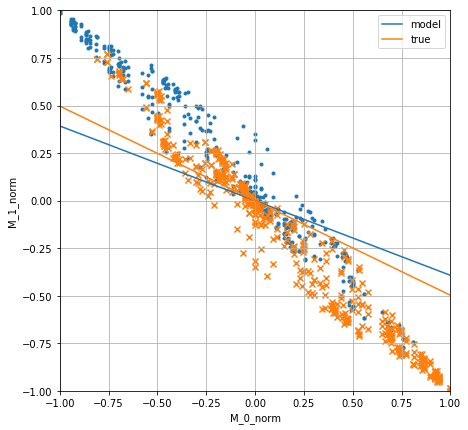

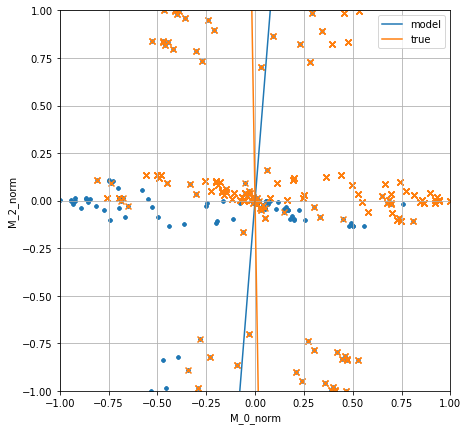

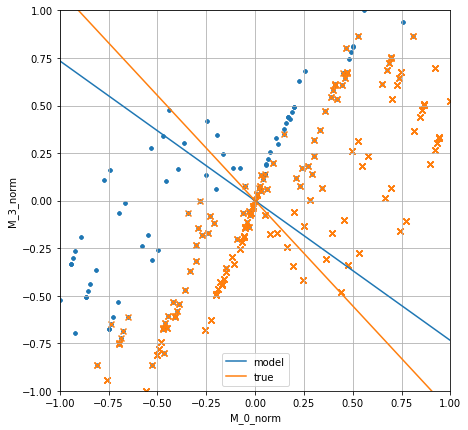

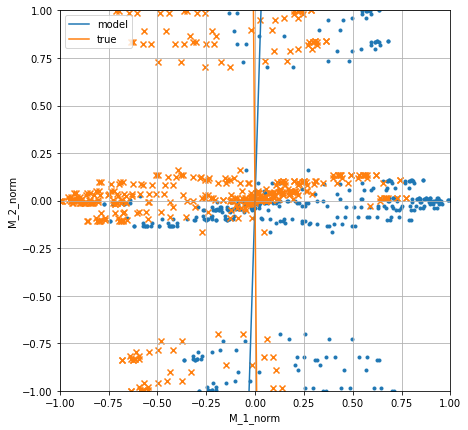

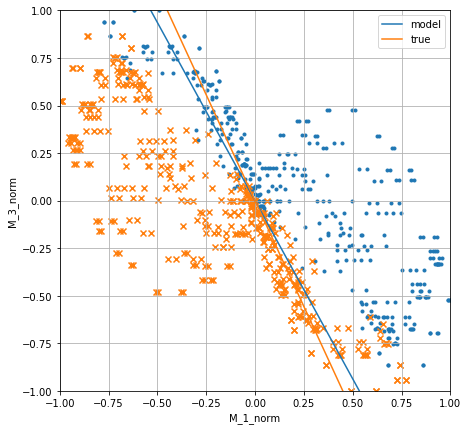

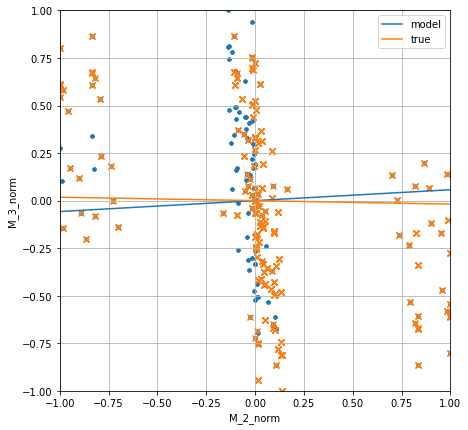

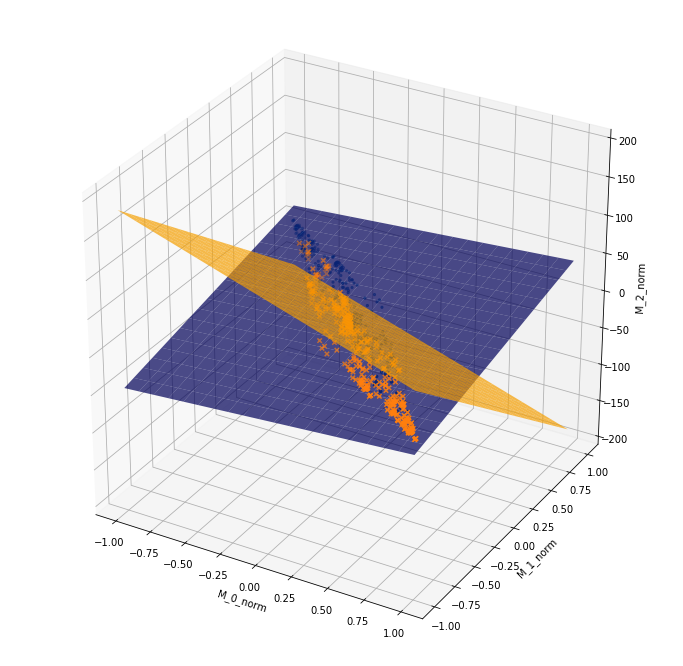

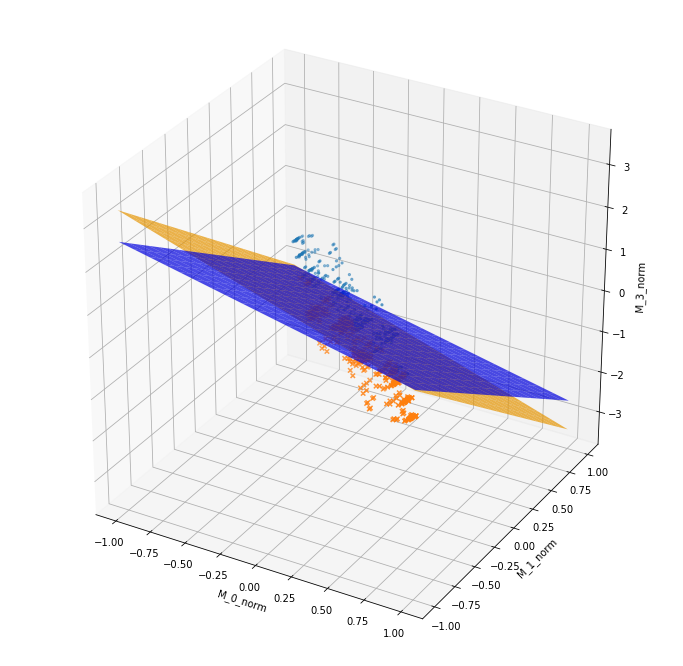

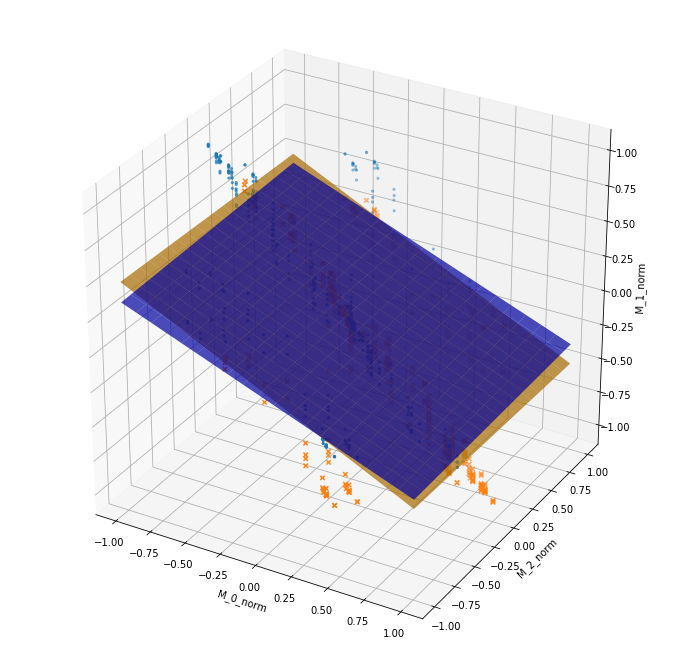

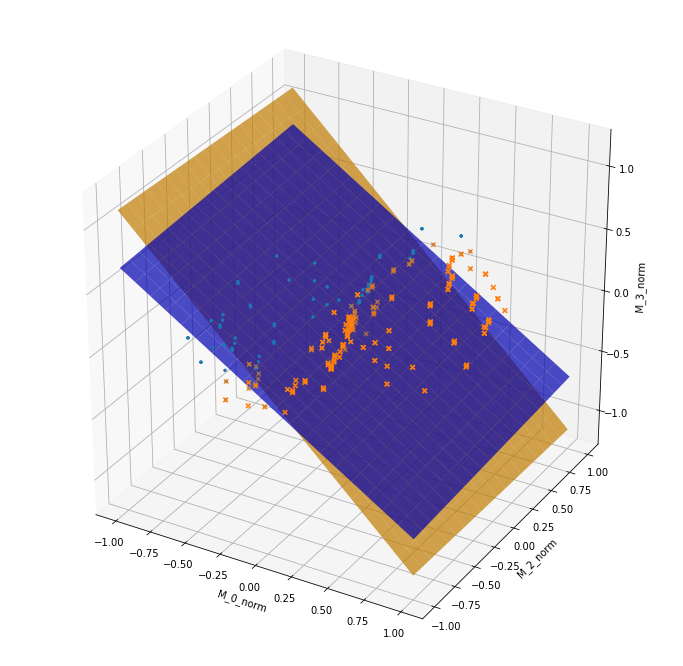

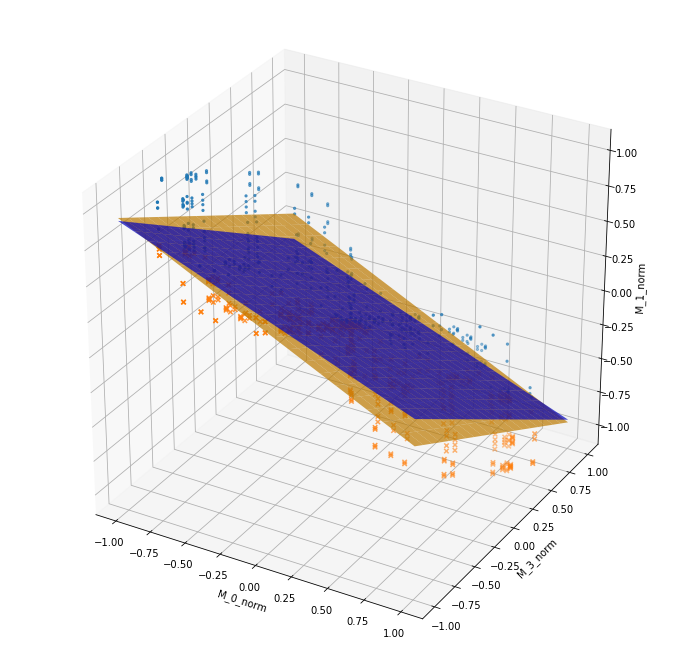

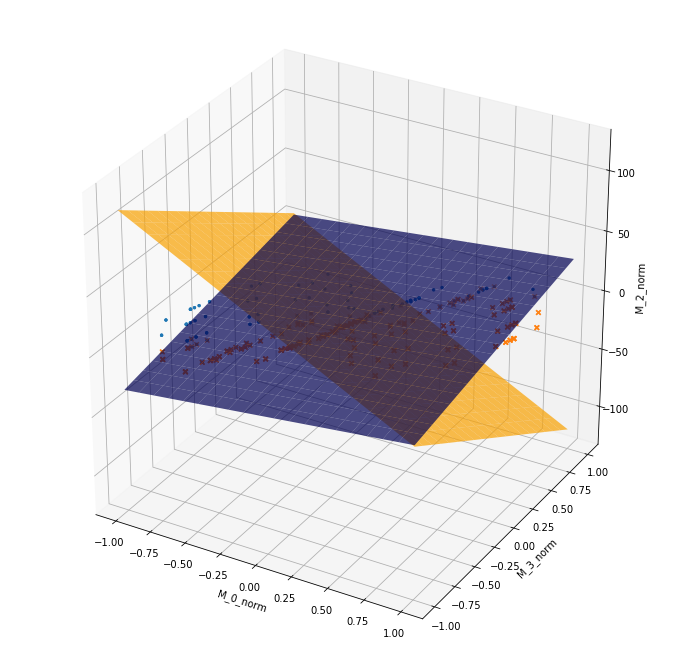

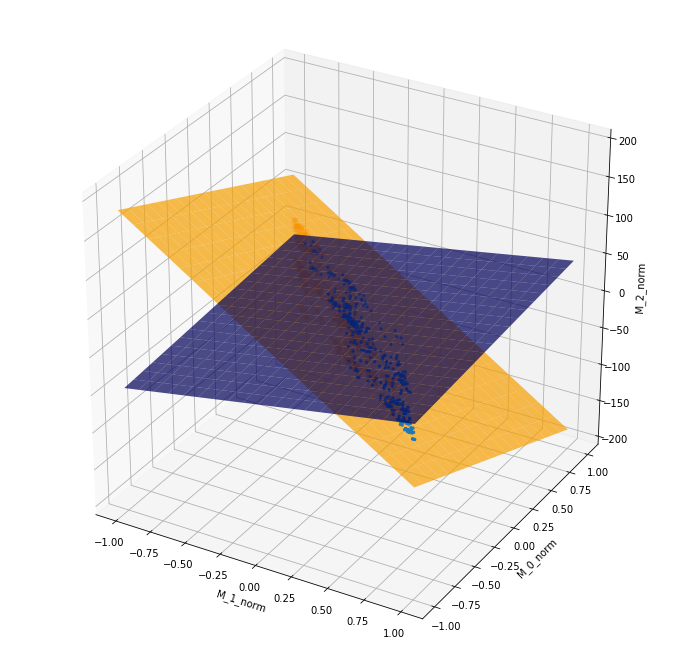

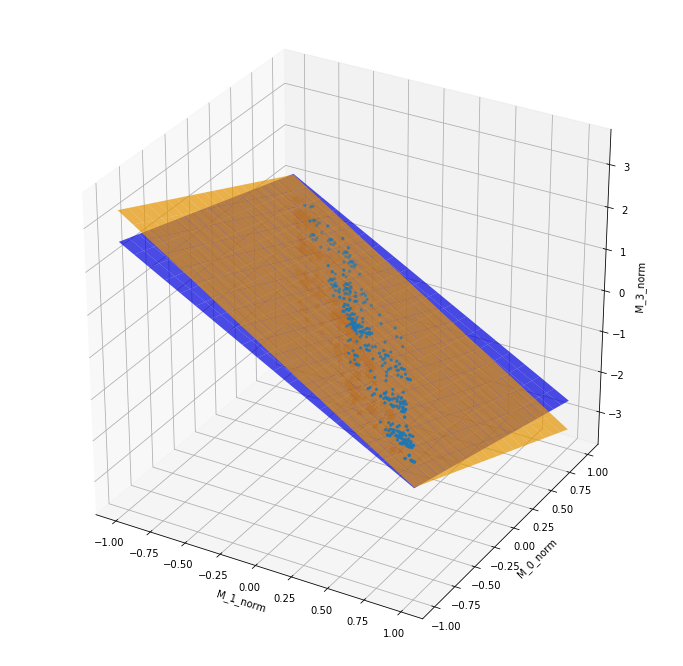

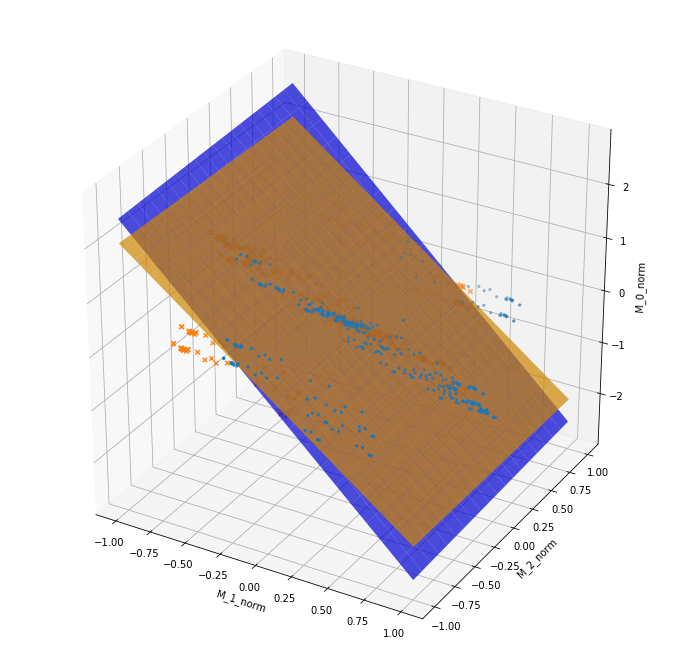

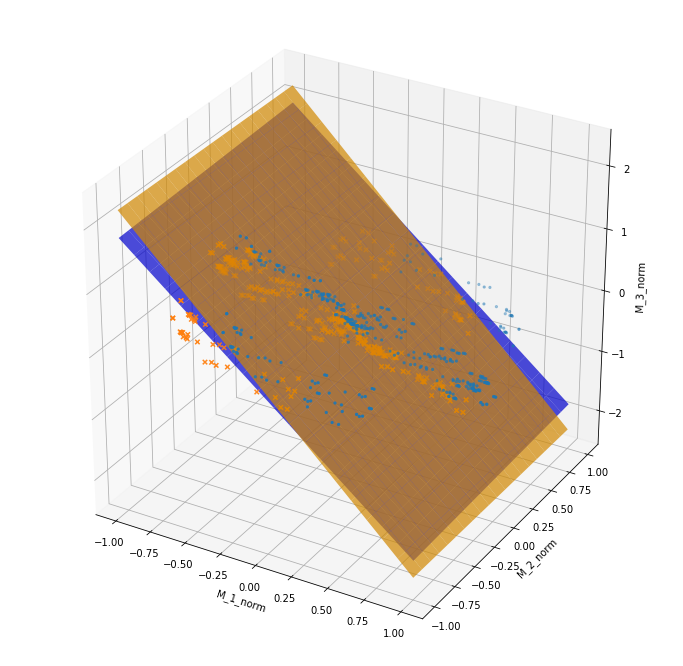

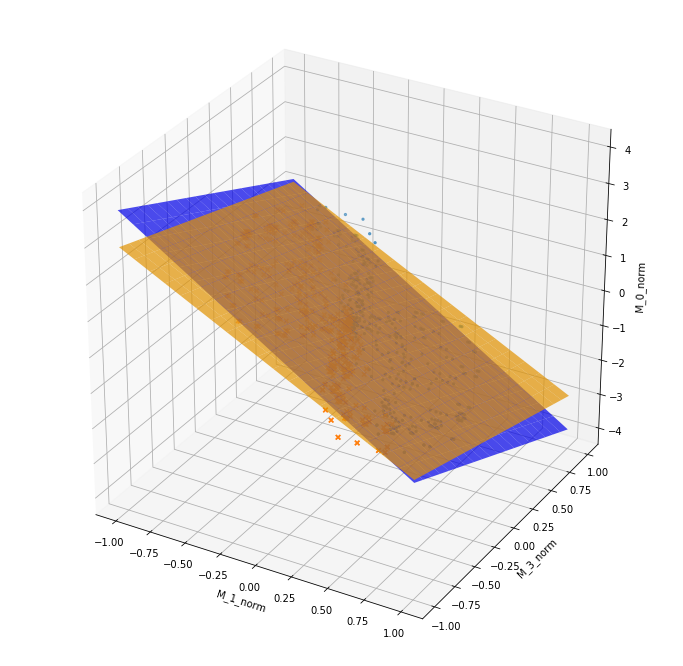

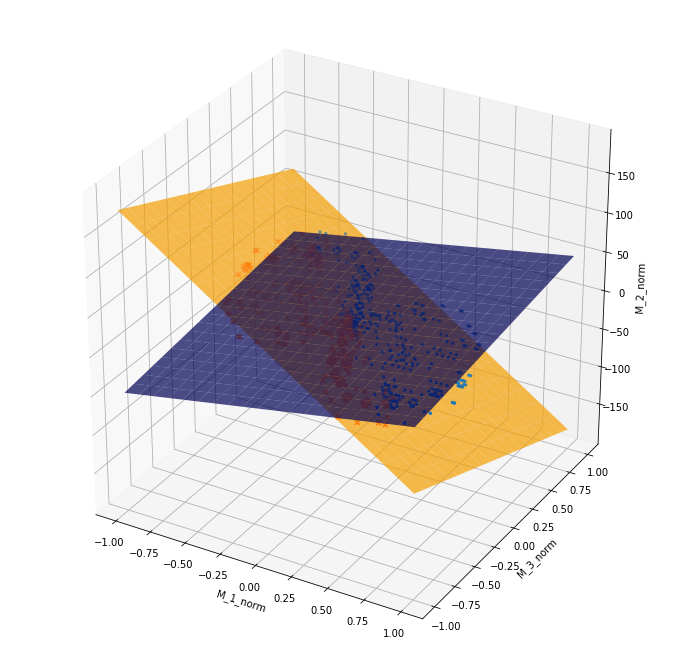

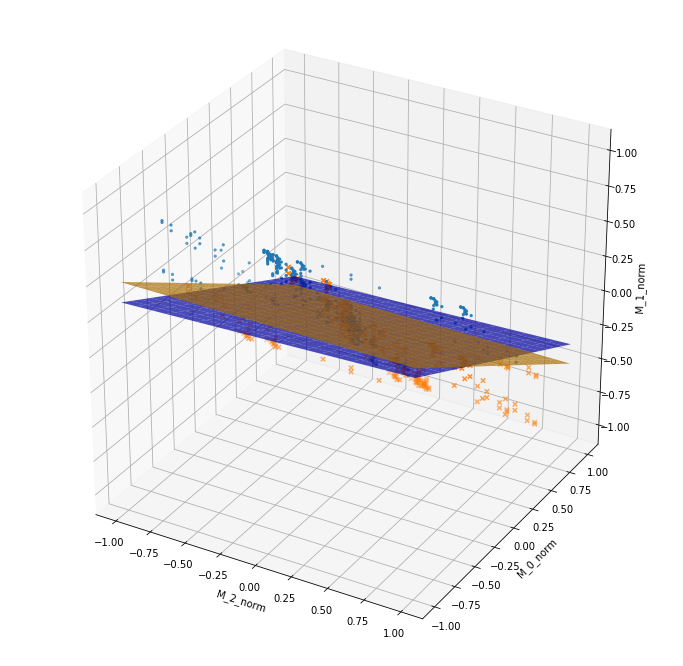

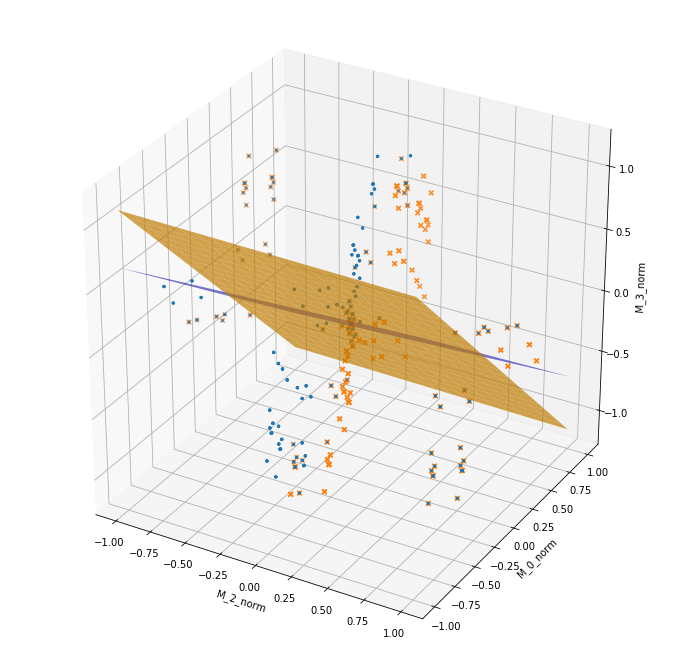

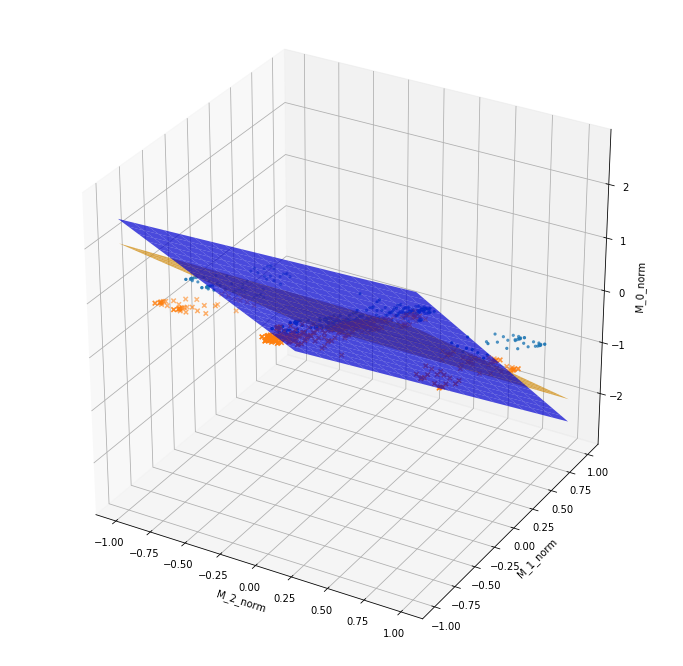

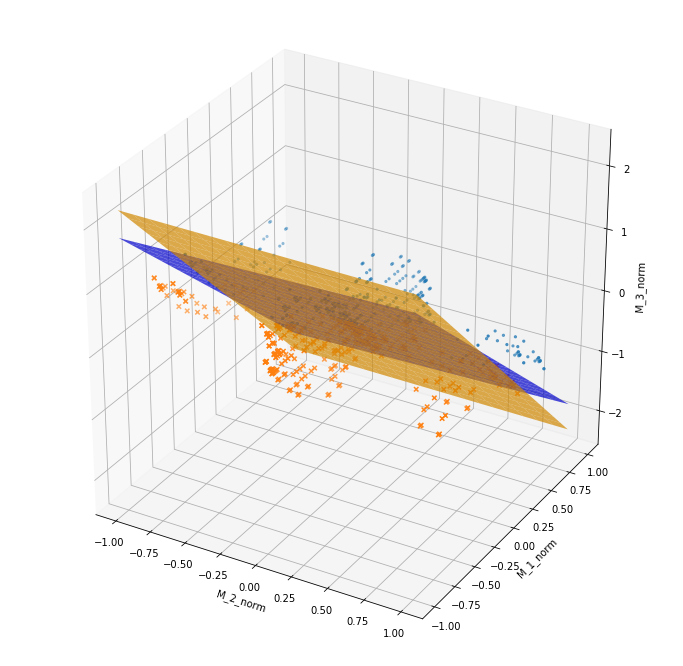

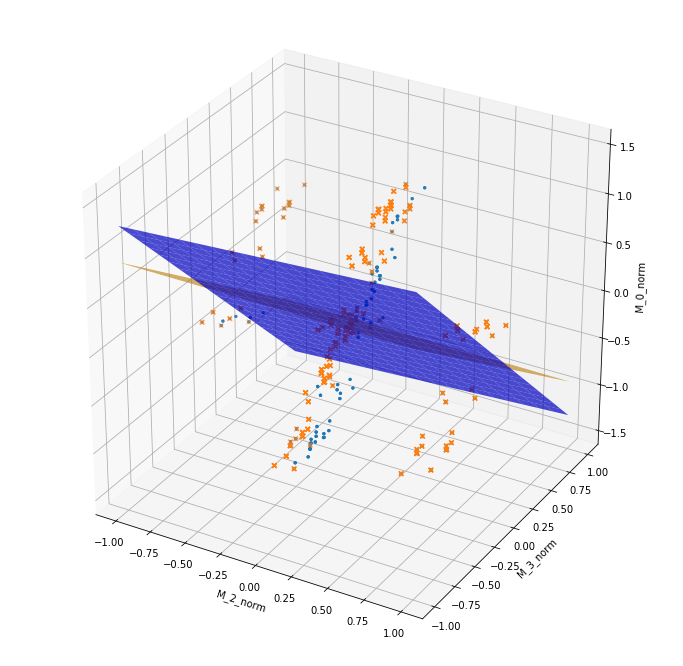

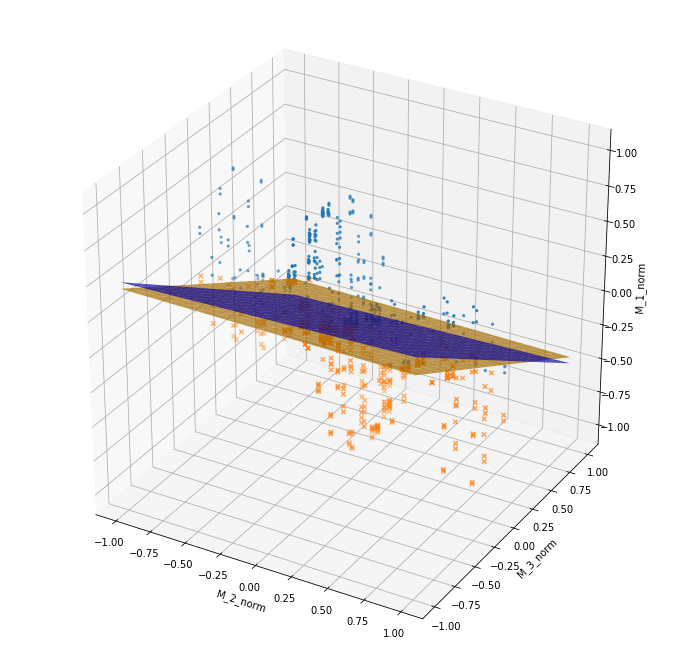

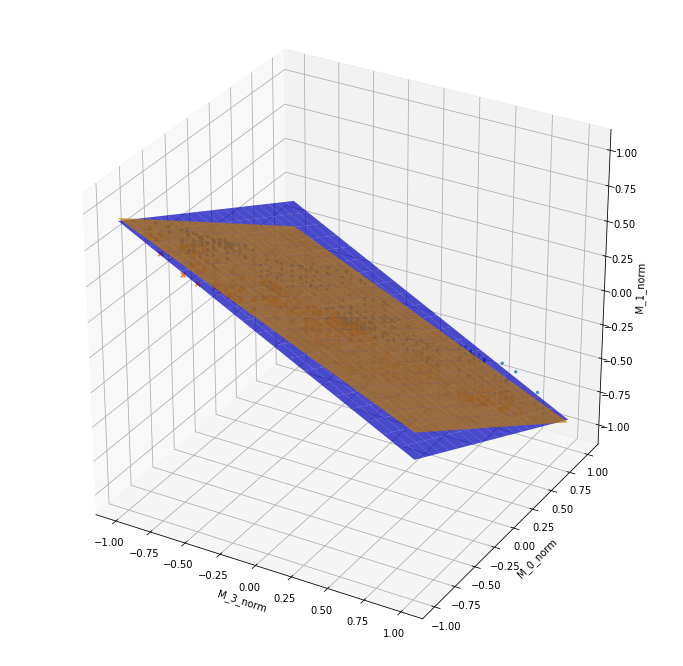

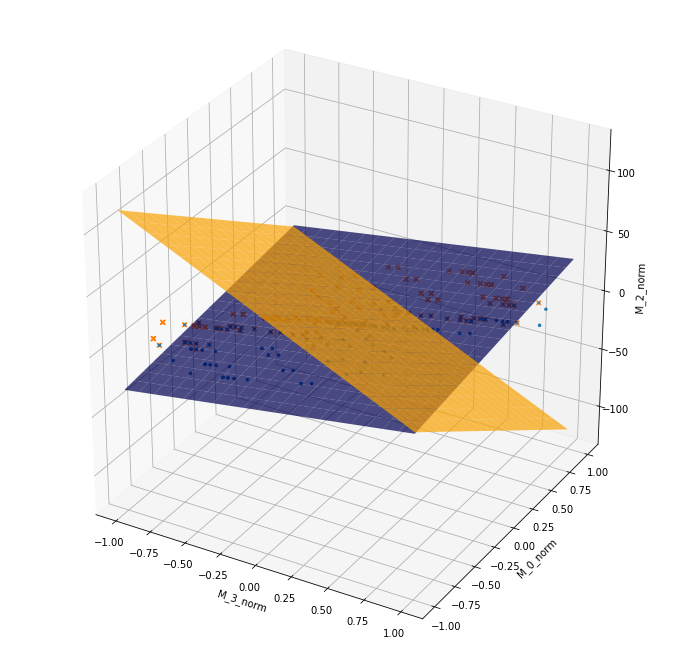

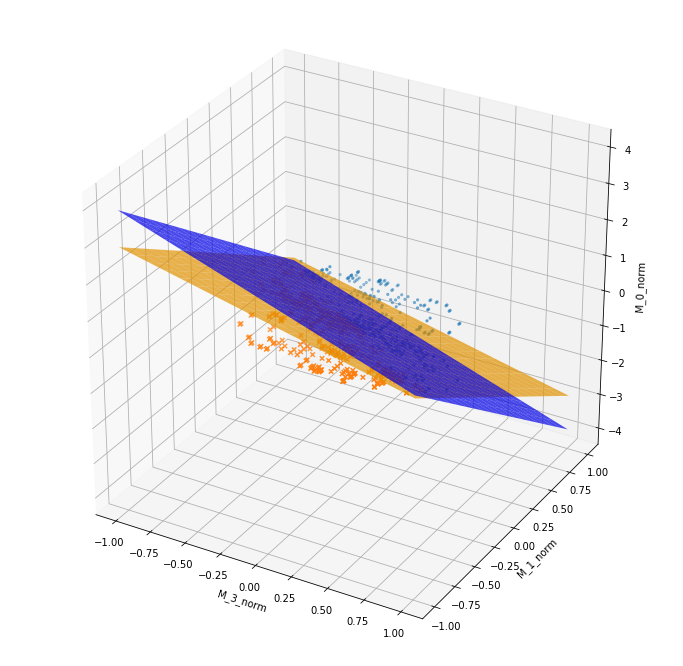

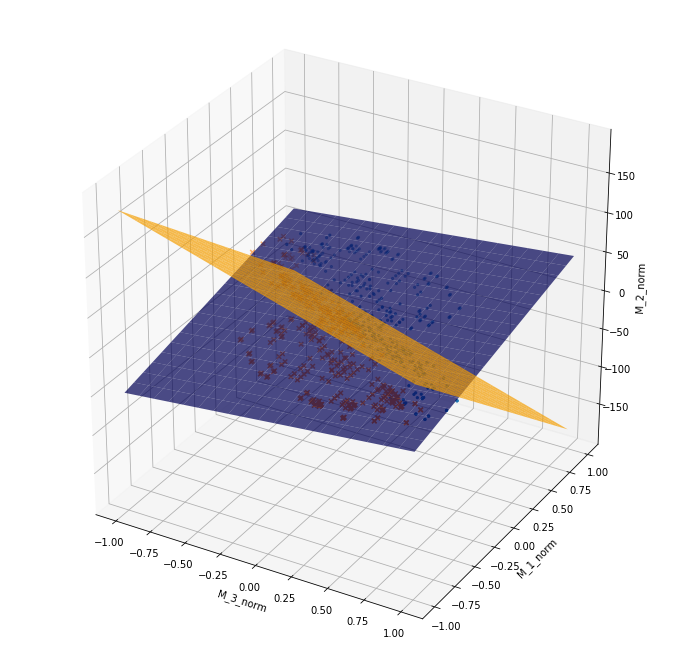

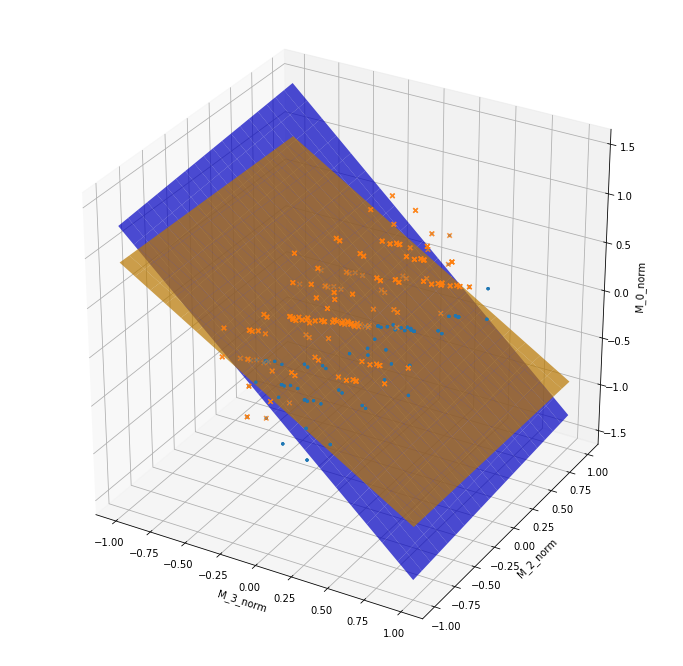

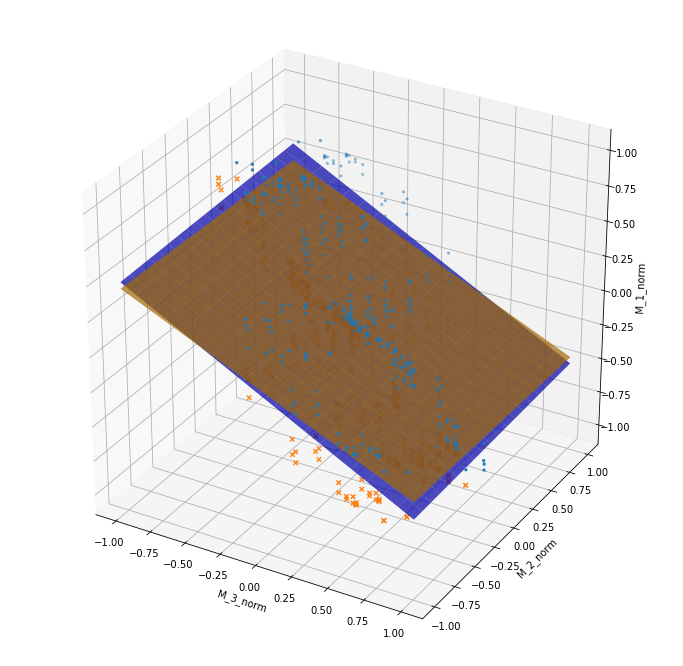

In [30]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

def module(u):
    ans = 0
    for elem in u:
        ans += elem * elem
    return ans

def sc(u, v):
    ans = 0;
    for i in range(len(u)):
        ans += u[i] * v[i];
    return ans;


def cos_n(u, v):
    return sc(u, v) / np.sqrt(module(u) * module(v))



def model_score(model, X, y, lam, show=False, max_M = [1, 1, 1, 1]):
    model_norm = list(model.coef_[0])
    print('Веса модели с нормализаванными признаками ', model_norm)
    model_coef = [0] * 4
    for i in range(4):
        model_coef[i] = model_norm[i] / max_M[i];
    print('Веса исходной модели ', model_coef)
    print('Заранее известные коэффициенты lam ', lam)
    print('Частота правильных ответов на обучающей выборке ', model.score(X, y))
    print('Косинус угла между векторами lam и model_coef', cos_n(model_coef, lam))
    if show:
        X1 = X[y==1]
        X0 = X[y==-1]
        for i in range(len(X.columns)):
            for j in range(i + 1, len(X.columns)):
                x=np.linspace(-1, 1)
                plt.figure(figsize=(7, 7))
                plt.scatter(x = X1[X.columns[i]], y=X1[X.columns[j]], marker='.')
                plt.scatter(x = X0[X.columns[i]], y=X0[X.columns[j]], marker='x')
                plt.plot(x, (-1)* model_norm[i] / model_norm[j] * x, label='model')
                plt.plot(x, (-1) * (lam[i] * max_M[i]) / (lam[j] * max_M[j]) * x, label='true')
                plt.xlim(-1,1)
                plt.ylim(-1,1)
                plt.legend()
                plt.xlabel(X.columns[i])
                plt.ylabel(X.columns[j])
                plt.grid()
                plt.show()
        for i in range(len(X.columns)):
            for j in range(len(X.columns)):
                for k in range(len(X.columns)):
                    if i == j or j == k or i == k:
                        continue
                    u, v = np.mgrid[-1:1:20j, -1:1:20j]
                    fig = plt.figure(figsize=(12, 12))
                    ax = fig.add_subplot(111, projection='3d')
                    ax.scatter(X1[X.columns[i]], X1[X.columns[j]], X1[X.columns[k]], marker='.')
                    ax.scatter(X0[X.columns[i]], X0[X.columns[j]], X0[X.columns[k]], marker='x')
                    ax.plot_surface(u , v, (-1)* (model_norm[i] * u + model_norm[j] * v) / model_norm[k], alpha=0.7, color='blue')
                    ax.plot_surface(u , v, (-1)* ((lam[i] * max_M[i]) * u + (lam[j] * max_M[j]) * v) / (lam[k] * max_M[k]), alpha=0.7, color='orange')
                    ax.set_xlabel(X.columns[i])
                    ax.set_ylabel(X.columns[j])
                    ax.set_zlabel(X.columns[k])
                    
                    plt.show()
    return model_coef
                

                
model_lam = model_score(model_norm, X_normalized, y, lam, True, max_M)
                

In [38]:
def A(lam):
    return (sigm1 * lam[0] - sigm2 * lam[1]) / (2 * lam[3]) - C0

def B(lam):
    return -sigm2 * lam[1] / (2 * lam[3] + 2 * (2 * np.pi) *(2 * np.pi) * lam[2])

A_model, B_model = A(model_lam), B(model_lam)
A_true, B_true = A(lam), B(lam)
A_model, B_model, A_true, B_true

(-85.42558312809656, -61.152187380860795, -84.95, -45.462983390431454)

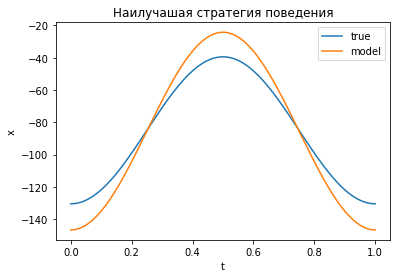

In [39]:
t_space = np.linspace(0, 1, 1001)

def x(A, B, t):
    return A + B * np.cos(2 * np.pi * t)

plt.plot(t_space, x(A_true, B_true, t_space), label='true')
plt.plot(t_space, x(A_model, B_model, t_space), label='model')
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Наилучашая стратегия поведения')
plt.show()